Heavily influenced by [this tutorial](https://towardsdatascience.com/pmf-for-recommender-systems-cbaf20f102f0) and [GitHub](https://github.com/ocontreras309/ML_Notebooks/blob/master/PMF_Recommender_Systems.ipynb).

# PMF for Recommender Systems

This is an implementation for Probabilistic Matrix Factorisation. We have made use of a subset of the IMDB dataset for training purposes.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error

Let's now download our dataset. We will also unzip it for further use.

Let's take a look at part of the ratings file to get an idea of the columns available.

In [2]:
df = pd.read_csv('ml_netflix.csv')
df.head()

,title,description,movieId,userId,rating
0,Grown Ups,Mourning the loss of their beloved junior high...,0,0,2.0
1,Grown Ups,Mourning the loss of their beloved junior high...,0,1,3.5
2,Grown Ups,Mourning the loss of their beloved junior high...,0,2,5.0
3,Grown Ups,Mourning the loss of their beloved junior high...,0,3,3.0
4,Grown Ups,Mourning the loss of their beloved junior high...,0,4,2.5


As part of the dataset, there is also another file that contains movie information, which includes the movie id, the title, the genre, among others. We can INNER JOIN the ratings and movies datasets to gain access to all data we will need for our analysis.

Deleting the popular movies. Decreases training time and not really useful to know that everyone enjoys popular movies. Want to see actually personalized recs.
But can comment out this function call in the 4th cell.

Let's now prepare our sparse review matrix. For this purpose, we first need to find out how many users and movies we have in our dataset. Additionally, we will set D to 5 dimensions.

In [3]:
def get_ratings_matrix(df, train_size=0.75):
    user_to_row = {}
    movie_to_column = {}
    df_values = df.values
    n_dims = 10
    parameters = {}
    
    uniq_users = np.unique(df_values[:, 3])
    uniq_movies = np.unique(df_values[:, 2])

    for i, user_id in enumerate(uniq_users):
        user_to_row[user_id] = i

    for j, movie_id in enumerate(uniq_movies):
        movie_to_column[movie_id] = j
    
    n_users = len(uniq_users)
    n_movies = len(uniq_movies)
    
    R = np.zeros((n_users, n_movies))
    
    df_copy = df.copy()
    train_set = df_copy.sample(frac=train_size, random_state=0)
    test_set = df_copy.drop(train_set.index)
    
    for index, row in train_set.iterrows():
        i = user_to_row[row.userId]
        j = movie_to_column[row.movieId]
        R[i, j] = row.rating

    return R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column

Let's now call this function and retrieve all necessary parameters.

In [4]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df, 0.8)
parameters = {}

We will now initialise our parameters. First the $V$ matrix can be initialised randomly using the following distribution:

\begin{equation}
\large
V \sim \mathcal N\left(0, \frac {1} {\lambda_V}\right)
\end{equation}

Let's remember that:

\begin{equation}
\large
U \in \mathbb R^{D\times N}, \qquad V \in \mathbb R^{D\times M}
\end{equation}

Where $N$ is __n_users__, $M$ is __n_movies__ and $D$ is __n_dims__.

In [5]:
def initialize_parameters(lambda_U, lambda_V):
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    parameters['U'] = U
    parameters['V'] = V
    parameters['lambda_U'] = lambda_U
    parameters['lambda_V'] = lambda_V

Let's now implement the function that updates U and V. The elements of both matrices can be updated using the following expressions:

\begin{equation}
\large
U_i=\left[\left(V_jV_j^T\right)_{j\in\Omega_{U_i}}+\lambda_UI\right]^{-1}\left(R_{ij}V_j^T\right)_{j\in\Omega_{U_i}}
\end{equation}

\begin{equation}
\large
V_j=\left[\left(U_iU_i^T\right)_{i\in\Omega_{V_j}}+\lambda_VI\right]^{-1}\left(R_{ij}U_i^T\right)_{i\in\Omega_{V_j}}
\end{equation}

In [6]:
def update_parameters():
    U = parameters['U']
    V = parameters['V']
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    
    for i in range(n_users):
        V_j = V[:, R[i, :] > 0]
        U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(R[i, R[i, :] > 0], V_j.T))
        
    for j in range(n_movies):
        U_i = U[:, R[:, j] > 0]
        V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(R[R[:, j] > 0, j], U_i.T))
        
    parameters['U'] = U
    parameters['V'] = V

Now let's implement the Log-a posteriori:

\begin{equation}
\large
L=-\frac 1 2 \left(\sum_{i=1}^N\sum_{j=1}^M(R_{ij}-U_i^TV_j)_{(i,j) \in \Omega_{R_{ij}}}^2+\lambda_U\sum_{i=1}^N\|U_i\|_{Fro}^2+\lambda_V\sum_{j=1}^M\|V_j\|_{Fro}^2\right)
\end{equation}

In [7]:
def log_a_posteriori():
    lambda_U = parameters['lambda_U']
    lambda_V = parameters['lambda_V']
    U = parameters['U']
    V = parameters['V']
    
    UV = np.dot(U.T, V)
    R_UV = (R[R > 0] - UV[R > 0])
    
    return -0.5 * (np.sum(np.dot(R_UV, R_UV.T)) + lambda_U * np.sum(np.dot(U, U.T)) + lambda_V * np.sum(np.dot(V, V.T)))

The __predict__ function allows us to predict the rating value given the __user_id__ and the __movie_id__ parameters. The value has been scaled within the range 0-5

In [8]:
def predict(user_id, movie_id):
    U = parameters['U']
    V = parameters['V']
    r_ij = U[:, user_to_row[user_id]].T.reshape(1, -1) @ V[:, movie_to_column[movie_id]].reshape(-1, 1)

    max_rating = parameters['max_rating']
    min_rating = parameters['min_rating']

    return 0 if max_rating == min_rating else ((r_ij[0][0] - min_rating) / (max_rating - min_rating)) * 5.0

The __evaluate__ function will calculate the __RMSE__ of the model given a dataset (train or test).

In [9]:
def rmse_evaluate(dataset):
    ground_truths = []
    predictions = []
    
    for index, row in dataset.iterrows():
        ground_truths.append(row.loc['rating'])
        predictions.append(predict(row.loc['userId'], row.loc['movieId']))
    
    return mean_squared_error(ground_truths, predictions, squared=False)

In [10]:
from utils.utils import get_users_faves, get_helper_vals

In [11]:
def get_recs(dataset):
    all_predictions = {}
    movie_to_column_items = np.array(list(movie_to_column.items()))

    user_5_df, user_4_df = get_users_faves(dataset)

    for user in dataset["userId"].unique():
        num_actual_likes = len(user_5_df[user_5_df['userId']==user])
        # if no 5 ratings, find number of 4 ratings
        if num_actual_likes == 0:
            num_actual_likes = len(user_4_df[user_4_df['userId']==user])
        predictions = np.zeros((n_movies, 1))

        for i, movie in enumerate(movie_to_column_items):
            predictions[i] = predict(user, movie[0])
            
        indices = np.argsort(-predictions, axis=0)

        predicted_likes = []
        for j in range(num_actual_likes):
            movie_id = int(movie_to_column_items[np.where(movie_to_column_items[:, 1] == indices[j])][0][0])
            predicted_likes.append(movie_id)
        all_predictions[user] = predicted_likes

    return all_predictions

In [12]:
def mapk(recommendations, user_5_df, user_4_df): 
    '''
    slightly different from the one in utils.utils because this workflow has train-test datasets
    and not every user is in both datasets
    '''
    # calculate MAP @ k
    # http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

    # for each user
    map_k = 0
    for user in recommendations:
        l = len(recommendations[user])
        user_actual = user_5_df[user_5_df['userId']==user]['movieId']
        if user_actual.empty:
            user_actual = user_4_df[user_4_df['userId']==user]['movieId']
        if user_actual.empty:
            continue
        sum = 0
        if l == 0:
            continue
        for k in range(1, l):
            # top k recommendations and top k actually rated movies for user
            user_rec = recommendations[user][:k]
            user_actual_k = set(user_actual[:k])
            # only add if the kth item was relevant
            if user_rec[-1] in user_actual_k:
                # find intersections
                user_rec = set(user_rec)
                intersection = list(user_rec & user_actual_k)
                # add precision to sum
                sum += len(intersection) / float(k)
        # divide by min(m, N)
        sum /= float(l)
        map_k += sum

    # print final map@k value
    map_k /= float(len(recommendations))
    print(f'MAP@K: {map_k}')
    return map_k

In [13]:
from sklearn.metrics.pairwise import cosine_similarity
def calc_personalization(recommendations): # nikki's
    # calculate personalization matrix
    # https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093
    # create num_user x num_movies
    personalization = np.zeros((n_users, n_movies))

    for row in recommendations:
        user = row
        for movie_ind in recommendations[row]:
            personalization[user][movie_ind] = 1

    cosine_sim = cosine_similarity(personalization, personalization)

    # compute average of upper triangle to get cosine similarity
    sum = 0
    denom = (n_users-1)*(n_users)/2
    for i in range(n_users-1):
        for j in range(i+1, n_users):
            sum += cosine_sim[i][j]

    similarity = sum/denom
    dissimilarity = 1 - similarity
    print(f'Personalization: {dissimilarity}')
    return dissimilarity

In [14]:
def mean_precision(recommendations, num_users, user_5_df, user_4_df): # mostly nikki's
    # http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html

    # for each user
    metric = 0
    for user in range(num_users):
        l = len(recommendations[user])
        user_actual = user_5_df[user_5_df['userId']==user]['movieId']
        if user_actual.empty:
            user_actual = user_4_df[user_4_df['userId']==user]['movieId']
        if user_actual.empty:
            continue

        if l == 0:
            continue

        user_actual = set(user_actual.values)
        # top k recommendations and top k actually rated movies for user
        user_rec = set(recommendations[user])
        # find intersections
        intersection = list(user_rec & user_actual)
        # add precision to sum
        metric += len(intersection) / float(l)

    metric /= float(num_users)
    print(f'MEAN PRECISION (NOT mAP): {metric}')
    return metric

In [15]:
def eval(recs, user_5_df, user_4_df, metric_type):
  if metric_type == 'MAPK':
    return mapk(recs, user_5_df, user_4_df)
  elif metric_type == 'PER':
    return calc_personalization(recs)
  elif metric_type == 'MEAN_PRECISION':
    return mean_precision(recs, n_users, user_5_df, user_4_df)

For the purposes of scaling, we need the maximum and minimum rating values.

In [16]:
def update_max_min_ratings():
    U = parameters['U']
    V = parameters['V']

    R = U.T @ V
    min_rating = np.min(R)
    max_rating = np.max(R)

    parameters['min_rating'] = min_rating
    parameters['max_rating'] = max_rating

The __train__ function implements the code necessary for training the model as well as recording the __RMSE__ values on the training and testing sets.

In [17]:
train_num_movies, train_num_users = get_helper_vals(train_set)
test_num_movies, test_num_users = get_helper_vals(test_set) 

train_user_5_df, train_user_4_df = get_users_faves(train_set)
test_user_5_df, test_user_4_df = get_users_faves(test_set)

step = 10
def train(n_epochs):
    initialize_parameters(0.3, 0.3)
    log_aps = []
    rmse_train, rmse_test = [], []

    update_max_min_ratings()

    rmse_train.append(rmse_evaluate(train_set))
    rmse_test.append(rmse_evaluate(test_set))
    
    for k in range(n_epochs):
        update_parameters()
        log_ap = log_a_posteriori()
        log_aps.append(log_ap)

        if (k + 1) % step == 0:
            update_max_min_ratings()

            rmse_train.append(rmse_evaluate(train_set))
            rmse_test.append(rmse_evaluate(test_set))
            
            print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

    update_max_min_ratings()

    return log_aps, rmse_train, rmse_test

Let's train our model!

In [18]:
log_ps, rmse_train, rmse_test = train(100)

Log p a-posteriori at iteration 10 : -4598.053309322365
Log p a-posteriori at iteration 20 : -3587.635891500947
Log p a-posteriori at iteration 30 : -3232.663508377583
Log p a-posteriori at iteration 40 : -3045.9397390678732
Log p a-posteriori at iteration 50 : -2930.5159606693205
Log p a-posteriori at iteration 60 : -2847.02175118128
Log p a-posteriori at iteration 70 : -2789.458489949354
Log p a-posteriori at iteration 80 : -2751.5478611455806
Log p a-posteriori at iteration 90 : -2728.309429382214
Log p a-posteriori at iteration 100 : -2710.360531613581


Now let's take a look at some graphs

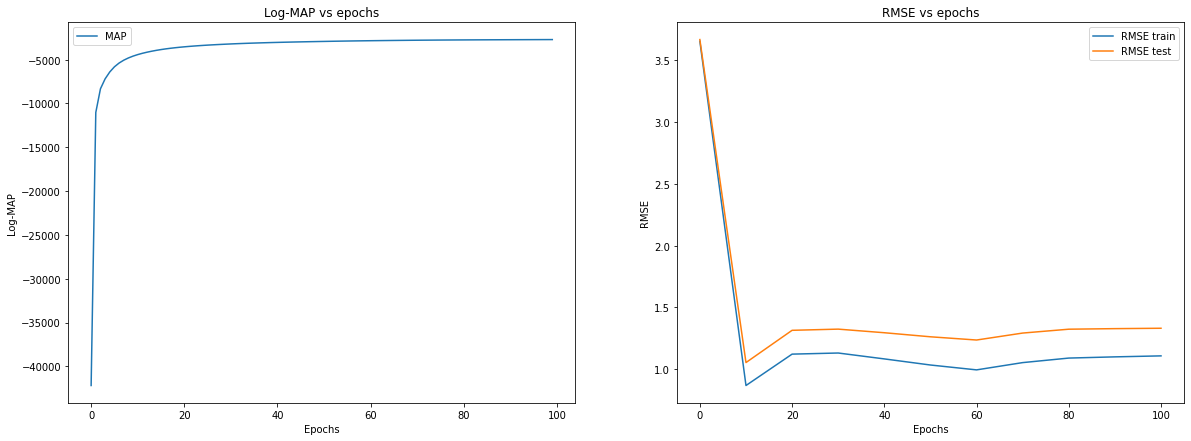

In [25]:
_, axes = plt.subplots(1, 2, figsize=(20, 7))
axes[0].plot(np.arange(len(log_ps)), log_ps, label='MAP')
axes[0].set_title('Log-MAP vs epochs')
axes[0].set_ylabel('Log-MAP')
axes[0].set_xlabel('Epochs')
axes[0].legend()


axes[1].plot(np.arange(0, len(rmse_train) * step, step), rmse_train, label='RMSE train')
axes[1].plot(np.arange(0, len(rmse_test) * step, step), rmse_test, label='RMSE test')
axes[1].set_title('RMSE vs epochs')
axes[1].set_ylabel('RMSE')
axes[1].set_xlabel('Epochs')
axes[1].legend()

plt.show()

Let's now evaluate our model on both the training and testing sets.

In [20]:
print('RMSE of training set:', rmse_evaluate(train_set))
print('RMSE of testing set:', rmse_evaluate(test_set))

RMSE of training set: 1.107856390029338
RMSE of testing set: 1.3313840214104453


# Train on Whole Dataset
Now we can get metrics like MAP@K and personalization without the weirdness of test leakage :)

In [21]:
R, train_set, test_set, n_dims, n_users, n_movies, user_to_row, movie_to_column = get_ratings_matrix(df, 1)
parameters = {}

In [28]:
train_num_movies, train_num_users = get_helper_vals(train_set)
train_user_5_df, train_user_4_df = get_users_faves(train_set)

initialize_parameters(0.3, 0.3)
log_aps = []
rmse, map_at_k, per, mp = [], [], [], []

update_max_min_ratings()

rmse.append(rmse_evaluate(train_set))
recs = get_recs(train_set)
map_at_k.append(eval(recs, train_user_5_df, train_user_4_df, 'MAPK'))
per.append(eval(recs, train_user_5_df, train_user_4_df, 'PER'))
mp.append(eval(recs, train_user_5_df, train_user_4_df, 'MEAN_PRECISION'))

for k in range(100):
    update_parameters()
    log_ap = log_a_posteriori()
    log_aps.append(log_ap)

    if (k + 1) % step == 0:
        update_max_min_ratings()

        rmse.append(rmse_evaluate(train_set))

        recs = get_recs(train_set)
        map_at_k.append(eval(recs, train_user_5_df, train_user_4_df, 'MAPK'))
        per.append(eval(recs, train_user_5_df, train_user_4_df, 'PER'))
        mp.append(eval(recs, train_user_5_df, train_user_4_df, 'MEAN_PRECISION'))

        print('Log p a-posteriori at iteration', k + 1, ':', log_ap)

update_max_min_ratings()

MAP@K: 6.527164639251455e-05
Personalization: 0.4119304082750871
MEAN PRECISION (NOT mAP): 0.00137922560981466
MAP@K: 0.008004229054437916
Personalization: 0.9541203993850229
MEAN PRECISION (NOT mAP): 0.07443842641471973
Log p a-posteriori at iteration 10 : -3918.4312514393946
MAP@K: 0.006387167729175917
Personalization: 0.9534556146579496
MEAN PRECISION (NOT mAP): 0.06882758830377868
Log p a-posteriori at iteration 20 : -2594.7270593481953
MAP@K: 0.006197076172401295
Personalization: 0.9549977315715036
MEAN PRECISION (NOT mAP): 0.06352828932458414
Log p a-posteriori at iteration 30 : -2185.2387668386777
MAP@K: 0.005113681420759363
Personalization: 0.955168600277593
MEAN PRECISION (NOT mAP): 0.05991519612280356
Log p a-posteriori at iteration 40 : -2021.6463513014205
MAP@K: 0.003644859019183957
Personalization: 0.9532885391626168
MEAN PRECISION (NOT mAP): 0.05879585461304018
Log p a-posteriori at iteration 50 : -1945.4758067091093
MAP@K: 0.0037065647791069446
Personalization: 0.9536503

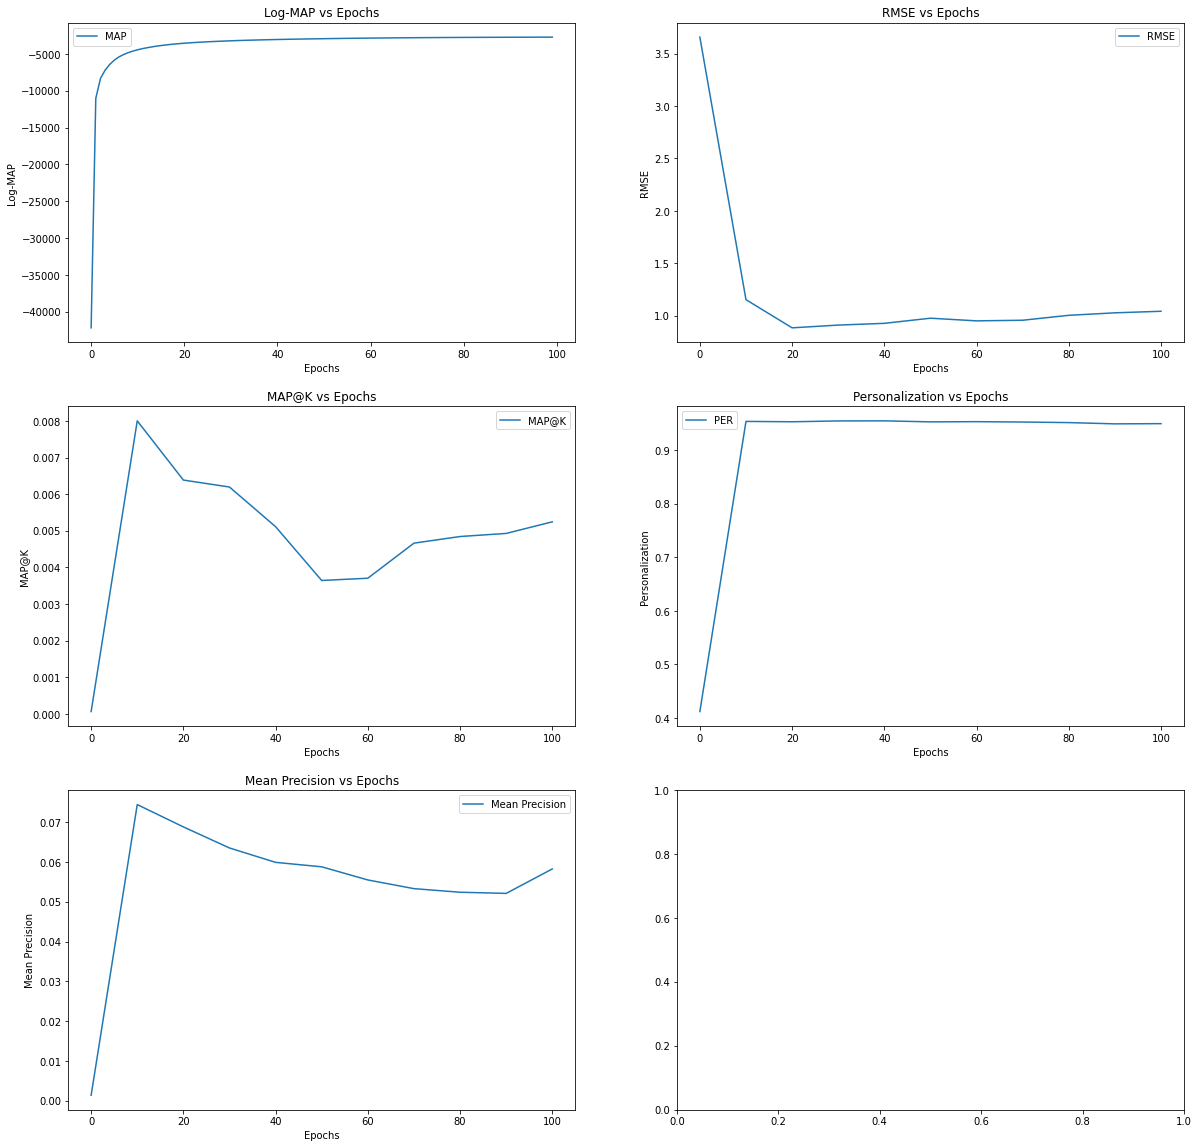

In [29]:
_, axes = plt.subplots(3, 2, figsize=(20, 20))

axes[0, 0].plot(np.arange(len(log_ps)), log_ps, label='MAP')
axes[0, 0].set_title('Log-MAP vs Epochs')
axes[0, 0].set_ylabel('Log-MAP')
axes[0, 0].set_xlabel('Epochs')
axes[0, 0].legend()

axes[0, 1].plot(np.arange(0, len(rmse) * step, step), rmse, label='RMSE')
axes[0, 1].set_title('RMSE vs Epochs')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].set_xlabel('Epochs')
axes[0, 1].legend()

axes[1, 0].plot(np.arange(0, len(map_at_k) * step, step), map_at_k, label='MAP@K')
axes[1, 0].set_title('MAP@K vs Epochs')
axes[1, 0].set_ylabel('MAP@K')
axes[1, 0].set_xlabel('Epochs')
axes[1, 0].legend()

axes[1, 1].plot(np.arange(0, len(per) * step, step), per, label='PER')
axes[1, 1].set_title('Personalization vs Epochs')
axes[1, 1].set_ylabel('Personalization')
axes[1, 1].set_xlabel('Epochs')
axes[1, 1].legend()

axes[2, 0].plot(np.arange(0, len(mp) * step, step), mp, label='Mean Precision')
axes[2, 0].set_title('Mean Precision vs Epochs')
axes[2, 0].set_ylabel('Mean Precision')
axes[2, 0].set_xlabel('Epochs')
axes[2, 0].legend()

plt.show()

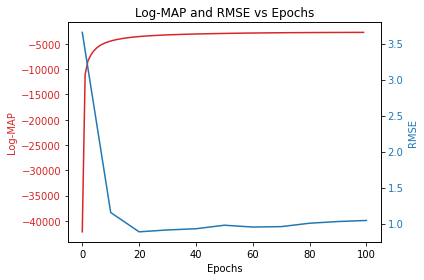

In [34]:
fig, ax1 = plt.subplots()

ax1.set_title('Log-MAP and RMSE vs Epochs')
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Log-MAP', color=color)
ax1.plot(np.arange(len(log_ps)), log_ps, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('RMSE', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(rmse) * step, step), rmse, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

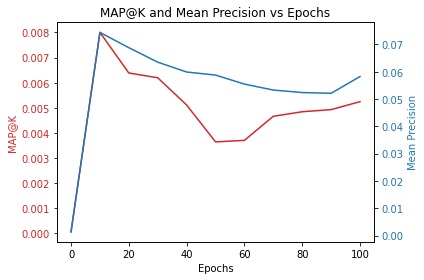

In [35]:
fig, ax1 = plt.subplots()

ax1.set_title('MAP@K and Mean Precision vs Epochs')
color = 'tab:red'
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MAP@K', color=color)
ax1.plot(np.arange(0, len(map_at_k) * step, step), map_at_k, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Mean Precision', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(mp) * step, step), mp, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [31]:
print('RMSE of training set:', rmse_evaluate(train_set))

recs = get_recs(train_set)
eval(recs, train_user_5_df, train_user_4_df, 'MAPK')
eval(recs, train_user_5_df, train_user_4_df, 'PER')
eval(recs, train_user_5_df, train_user_4_df, 'MEAN_PRECISION')

RMSE of training set: 1.0430974999719582
MAP@K: 0.005246560462967238
Personalization: 0.949935693393358
MEAN PRECISION (NOT mAP): 0.0582627060740847


0.0582627060740847